# RQ2 Analysis
This notebook contains the analysis for RQ2. The goal of this analysis is to understand the evolution of the serialization format used in the dataset over the years.

## Select the dataset to analyze

In [25]:
group_under_analysis = 'legacy'  # change this to 'legacy' or 'recent' to analyze the corresponding dataset

## Load the data
The data is loaded from the `read_repositories_evolution` function, which reads the evolution of repositories from a CSV file. The data contains the commit hash, date, repository URL, and serialization format for each model file in the tree at the time.

In [26]:
from scripts.notebooks.nb_utils import read_repositories_evolution

# model files per repository and the elapsed days between the commit and safetensors' release date
df = read_repositories_evolution(group_under_analysis)
df['year'] = df['date'].dt.year
df['year'] = df['year'].astype(int)  # set year as an integer
df['month'] = df['date'].dt.to_period('M')
year_range = list(range(df['year'].min(), df['year'].max() + 1))
df.head(5)


100%|██████████| 51900/51900 [00:00<00:00, 71699.04commit/s]


,repo_url,commit_hash,model_file_path,serialization_format,message,author,date,is_in_commit,elapsed_days,change_status,year,month
0,vinai/bartpho-syllable-base,1169c4a5308bd767be5104685eff93f2365e0a49,vinai/bartpho-syllable-base/pytorch_model.bin,torch.save,Upload sentencepiece.bpe.model,Dat Quoc Nguyen,2022-08-19 10:28:45,False,-34,,2022,2022-08
1,vinai/bartpho-syllable-base,1169c4a5308bd767be5104685eff93f2365e0a49,vinai/bartpho-syllable-base/sentencepiece.bpe....,ONNX,Upload sentencepiece.bpe.model,Dat Quoc Nguyen,2022-08-19 10:28:45,True,-34,+,2022,2022-08
2,vinai/bartpho-syllable-base,b0fdd03a9d51ef3df571d9a4d77467ca07cc249e,vinai/bartpho-syllable-base/pytorch_model.bin,torch.save,Upload model,Dat Quoc Nguyen,2022-08-19 10:23:41,True,-34,+,2022,2022-08
3,nlpie/tiny-biobert,e529c7b7b8a524beb015404d6c092d5816c5a60e,nlpie/tiny-biobert/pytorch_model.bin,torch.save,Third version of the tiny-biobert model.,Mojtaba aka Omid Rohanian,2022-08-20 14:34:18,True,-33,*,2022,2022-08
4,nlpie/tiny-biobert,11263e77fe2cadd48ac6f1a11c347ba873a82c45,nlpie/tiny-biobert/pytorch_model.bin,torch.save,Second version of the tiny-biobert model.,Mojtaba aka Omid Rohanian,2022-08-20 07:27:03,True,-33,*,2022,2022-08


## Prepare the data
For each repository, we want to find the last commit hash per year. If a repository does not have a commit hash for a specific year, we will use the last commit hash from the previous year(s).

In [27]:
import pandas as pd
# find the last commit hash per repository per year
df_last_hash = df.sort_values('date').drop_duplicates(['repo_url', 'year'], keep='last')
df_last_hash = df_last_hash[['repo_url', 'year', 'commit_hash', 'date']]

# ensure that all repos have one hash a year, if not, use last years'  hash
last_hash_per_repo = { (r['repo_url'], r['year']): r for _, r in df_last_hash.iterrows() }
for repo_url in df['repo_url'].unique():
    for year in year_range:
        key = (repo_url, year)
        if key not in last_hash_per_repo:
            # find the last commit hash from the previous year(s)
            for y in range(year, df['year'].min() - 1, -1):
                if (repo_url, y) in last_hash_per_repo:
                    df_last_hash = pd.concat([df_last_hash, pd.DataFrame({
                        'repo_url': [repo_url],
                        'year': [year],
                        'commit_hash': [last_hash_per_repo[(repo_url, y)]['commit_hash']],
                        'date': [last_hash_per_repo[(repo_url, y)]['date']]
                    })], ignore_index=True)
                    break

# df_last_hash[df_last_hash['repo_url'] == 'google-bert/bert-base-chinese']
df_last_hash

,repo_url,year,commit_hash,date
0,google-bert/bert-base-chinese,2019,950c40988e07db03a2607e82a1674d6b37491223,2019-09-23 15:48:20
1,google-bert/bert-base-multilingual-cased,2019,ebdb80f5e8045cb7f0b43f23f1e83314e05a985f,2019-09-23 15:48:20
2,google-bert/bert-base-multilingual-uncased,2019,02732585e9537735787afcdf8548d2b01caa431c,2019-09-23 15:48:20
3,google-bert/bert-base-german-cased,2019,ca80a78ef12ccb3145dfbc8bf0fe19965827a174,2019-09-23 15:48:20
4,google-bert/bert-base-cased,2019,e76fcde176cc191c231702e4311a54dd14f8f6bb,2019-09-23 15:48:20
...,...,...,...,...
6311,anshajgoyal/Parakeet_Paraphraser_BART,2023,0cda074fc0480619355fae69669857773153fc76,2022-09-20 15:32:09
6312,anshajgoyal/Parakeet_Paraphraser_BART,2024,0cda074fc0480619355fae69669857773153fc76,2022-09-20 15:32:09
6313,pszemraj/long-t5-tglobal-large-pubmed-3k-books...,2023,95c446c31b2867b2e5f4472630aeaf1faf1e90f5,2022-09-20 17:23:53
6314,pszemraj/long-t5-tglobal-large-pubmed-3k-books...,2024,95c446c31b2867b2e5f4472630aeaf1faf1e90f5,2022-09-20 17:23:53


In [28]:
# filter df such that it  only keeps the rows in df if the commit hash is the last commit hash in the repository URL
df = df.merge(df_last_hash, on=['repo_url', 'year', 'date', 'commit_hash'], how='inner')
print("Min date", df['date'].min(), "Max date", df['date'].max())

Min date 2019-09-23 15:48:20 Max date 2024-12-30 11:22:26


## Visualization of serialization format distribution over the years

In [29]:
title_suffix = f'({group_under_analysis.capitalize()} Repositories)' if group_under_analysis != 'both' else '(All Repositories)'
fig_dimensions = (7, 4) if group_under_analysis != 'recent' else (6, 4)
color_map = {
    "ONNX": "#1f77b4",
    "h5/hdf5": "#ff7f0e",
    "joblib": "#2ca02c",
    "numpy": "#d62728",
    "pickle": "#9467bd",
    "safetensors": "#8c564b",
    "torch.save": "#e377c2",
}

### Stacked Bar Chart

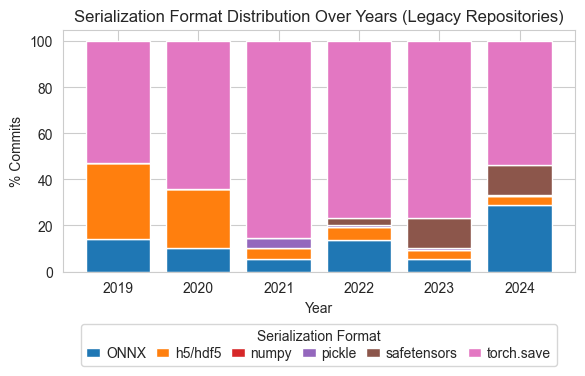

In [30]:
from nb_utils import RESULTS_DIR
import matplotlib.pyplot as plt
import numpy as np

# Sample data
df = df[df['serialization_format'] != 'undetermined']
# Compute a slice of the DataFrame with the relevant columns
df_by_date = df[['year', 'serialization_format']]

# Group by year and serialization format, then count occurrences
grouped = df_by_date.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Normalize the values to 100%
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=fig_dimensions)  # Set the figure size based on the group under analysis

# Cumulative values for stacked bars
cumulative_values = np.zeros(len(grouped_percentage))

for serialization_format in grouped_percentage.columns:
    ax.bar(grouped_percentage.index, grouped_percentage[serialization_format],
           bottom=cumulative_values, label=serialization_format, color=color_map[serialization_format])
    cumulative_values += grouped_percentage[serialization_format]

# Add labels and title
ax.set_ylabel('% Commits')
ax.set_xlabel('Year')
ax.set_xticks(year_range)  # Tick every year
ax.set_title(f'Serialization Format Distribution Over Years {title_suffix}')
# Move the legend outside  the plot
ax.legend(title='Serialization Format', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=7,
          labelspacing=0.2,  # Reduce vertical space between labels
          handlelength=1.0,  # Shorter line handles
          handletextpad=0.4,  # Less space between handle and text
          borderaxespad=0.3,  # Padding between legend and axes
          borderpad=0.4,  # Padding inside the legend box
          columnspacing=0.7  # Horizontal space between columns (if used)
          )
# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# save as pdf
plt.savefig(RESULTS_DIR / f'RQ2FormatsStacked_{group_under_analysis}.pdf', format='pdf', bbox_inches='tight')
plt.show()



### Line Chart

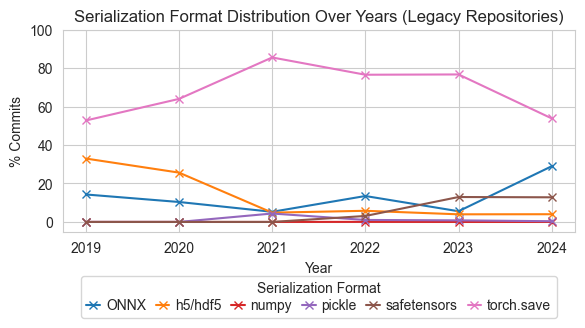

In [31]:
from nb_utils import RESULTS_DIR
import matplotlib.pyplot as plt

# Group by year and serialization format, then count occurrences
grouped = df.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Normalize the values to 100%
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot the line chart
fig, ax = plt.subplots(figsize=fig_dimensions)  # Set the figure size based on the group under analysis
# make y-axis range from 0 to 100
ax.set_ylim(-5, 100)

# Plot lines for each serialization format
for serialization_format in grouped_percentage.columns:
    ax.plot(grouped_percentage.index, grouped_percentage[serialization_format], marker='x', label=serialization_format,color=color_map[serialization_format])

# Add labels and title
ax.set_ylabel('% Commits')
ax.set_xlabel('Year')
ax.set_xticks(year_range)  # Tick every year
ax.set_title(f'Serialization Format Distribution Over Years {title_suffix}')
# Move the legend outside  the plot
ax.legend(title='Serialization Format', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=7,
          # fontsize='small',
          labelspacing=0.2,  # Reduce vertical space between labels
          handlelength=1.0,  # Shorter line handles
          handletextpad=0.4,  # Less space between handle and text
          borderaxespad=0.3,  # Padding between legend and axes
          borderpad=0.4,  # Padding inside the legend box
          columnspacing=0.7  # Horizontal space between columns (if used)
          )

# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0.1, 0.85, 1])  # Adjust the rectangle to fit the legend

# save as pdf
plt.savefig(RESULTS_DIR / f'RQ2FormatsDistribution_{group_under_analysis}.pdf', format='pdf', bbox_inches='tight')

plt.show()

### Line Chart Repository-level breakdown:
We group by repo creation date buckets (e.g., month of repo creation) and compute the first format being used in the repo (we do so by grabbing first commit adding model files, whatever those might be) to see whether newer repos adopt it more quickly than older ones.

In [32]:
# import pandas as pd
# # Select the last commit for each repository within each month
# last_monthly_commit_df = df.groupby(['repo_url', 'month']).last().reset_index()
#
# # find the last commit hash per repository per year
# df_last_monthly_hash = df.sort_values('date').drop_duplicates(['repo_url', 'month'], keep='last')
# df_last_monthly_hash = df_last_monthly_hash[['repo_url', 'month', 'commit_hash', 'date']]
#
# # ensure that all repos have one hash a year, if not, use last years'  hash
# last_monthly_hash_per_repo = { (r['repo_url'], r['month']): r for _, r in df_last_monthly_hash.iterrows() }
# for repo_url in df['repo_url'].unique():
#     for year in year_range:
#         for month in range(1, 13):
#             # create a key for the repo_url and year
#             key = (repo_url, f"{year}-{month:02d}")
#             if key not in last_monthly_hash_per_repo:
#                 # find the last commit hash from the previous year(s)
#                 for y in range(year, df['year'].min() - 1, -1):
#                     for m in range(1, 13):
#                         # create a key for the repo_url and year
#                         if (repo_url, f"{y}-{m:02d}") in last_monthly_hash_per_repo:
#                             df_last_monthly_hash = pd.concat([df_last_monthly_hash, pd.DataFrame({
#                                 'repo_url': [repo_url],
#                                 'month': [f"{year}-{month:02d}"],
#                                 'commit_hash': [last_monthly_hash_per_repo[(repo_url, f"{y}-{m:02d}")]['commit_hash']],
#                                 'date': [last_monthly_hash_per_repo[(repo_url, f"{y}-{m:02d}")]['date']]
#                             })], ignore_index=True)
#                             break

In [33]:
# last_monthly_hash_per_repo[('google-bert/bert-base-chinese', '2019-06')]
df_last_monthly_hash[df_last_monthly_hash['repo_url'] == 'google-bert/bert-base-chinese'].head(10)

,repo_url,month,commit_hash,date
26956,google-bert/bert-base-chinese,2019-09,950c40988e07db03a2607e82a1674d6b37491223,2019-09-23 15:48:20
26952,google-bert/bert-base-chinese,2022-11,84b432f646e4047ce1b5db001d43a348cd3f6bd0,2022-11-16 18:23:25


### (WIP) Line Chart with Counts

In [34]:
"""
import matplotlib.pyplot as plt


# Filter out rows with 'undetermined' serialization format
filtered_df = df[df['serialization_format'] != 'undetermined']
# Group by year and serialization format, then count occurrences
grouped_counts = filtered_df.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Set the size of the figure (width, height)
fig, ax = plt.subplots(figsize=fig_dimensions)  # Set the figure size based on the group under analysis

# Plot the line chart with counts
for serialization_format in grouped_counts.columns:
    ax.plot(grouped_counts.index, grouped_counts[serialization_format], marker='x', label=serialization_format)

# Add labels and title
ax.set_ylabel('# Model Files')
ax.set_xlabel('Year')
ax.set_title(f'Serialization Format Cumulative Totals Over Years {title_suffix}')

# Move the legend outside of the plot
ax.legend(title='Serialization Format',  bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=7)

# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0.3, 0.85, 1])

plt.show()
"""

"\nimport matplotlib.pyplot as plt\n\n\n# Filter out rows with 'undetermined' serialization format\nfiltered_df = df[df['serialization_format'] != 'undetermined']\n# Group by year and serialization format, then count occurrences\ngrouped_counts = filtered_df.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)\n\n# Set the size of the figure (width, height)\nfig, ax = plt.subplots(figsize=fig_dimensions)  # Set the figure size based on the group under analysis\n\n# Plot the line chart with counts\nfor serialization_format in grouped_counts.columns:\n    ax.plot(grouped_counts.index, grouped_counts[serialization_format], marker='x', label=serialization_format)\n\n# Add labels and title\nax.set_ylabel('# Model Files')\nax.set_xlabel('Year')\nax.set_title(f'Serialization Format Cumulative Totals Over Years {title_suffix}')\n\n# Move the legend outside of the plot\nax.legend(title='Serialization Format',  bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=7)\n\n# Adjust

### (WIP) Visualization monthly

In [35]:
"""

import pandas as pd
from scripts.notebooks.nb_utils import read_repositories_evolution
# Load the CSV file
df = read_repositories_evolution(group_under_analysis)


# Display the first few rows to understand the structure of the data
df.head()
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the month-year period for grouping
df['month'] = df['date'].dt.to_period('M')

# Sort by date to identify the last commit within each group
df = df.sort_values(by=['repo_url', 'month', 'date'])

# Select the last commit for each repository within each month
last_commit_df = df.groupby(['repo_url', 'month']).last().reset_index()

# Count the occurrences of each serialization format per month
serialization_distribution = last_commit_df.groupby(['month', 'serialization_format']).size().unstack(fill_value=0)

# Plotting the distribution using a line chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
serialization_distribution.plot(kind='line', marker='x', figsize=(14, 7))
plt.title('Monthly Distribution of Serialization Formats (Last Commit per Repo) ' + title_suffix)
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Serialization Format')
plt.tight_layout()
plt.show()
"""

"\n\nimport pandas as pd\nfrom scripts.notebooks.nb_utils import read_repositories_evolution\n# Load the CSV file\ndf = read_repositories_evolution(group_under_analysis)\n\n\n# Display the first few rows to understand the structure of the data\ndf.head()\n# Convert the 'date' column to datetime format\ndf['date'] = pd.to_datetime(df['date'])\n\n# Extract the month-year period for grouping\ndf['month'] = df['date'].dt.to_period('M')\n\n# Sort by date to identify the last commit within each group\ndf = df.sort_values(by=['repo_url', 'month', 'date'])\n\n# Select the last commit for each repository within each month\nlast_commit_df = df.groupby(['repo_url', 'month']).last().reset_index()\n\n# Count the occurrences of each serialization format per month\nserialization_distribution = last_commit_df.groupby(['month', 'serialization_format']).size().unstack(fill_value=0)\n\n# Plotting the distribution using a line chart\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(12, 6))\nserializ

In [36]:
"""
# Calculate the percentage distribution instead of raw counts
serialization_percentage_distribution = serialization_distribution.div(serialization_distribution.sum(axis=1), axis=0) * 100
# Exclude 'undetermined' serialization format
serialization_percentage_distribution = serialization_percentage_distribution.drop(columns=['undetermined'], errors='ignore')


# # Plotting the percentage distribution using a line chart
# plt.figure(figsize=(12, 6))
# serialization_percentage_distribution.plot(kind='line', marker='x', figsize=(14, 7))
# plt.title('Monthly Percentage Distribution of Serialization Formats (Last Commit per Repo)')
# plt.xlabel('Month')
# plt.ylabel('Percentage')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.legend(title='Serialization Format')
# plt.tight_layout()
# plt.show()

# Plotting the modified chart
plt.figure(figsize=(12, 6))
ax = serialization_percentage_distribution.plot(kind='line', marker='x', figsize=(14, 7))

plt.title('Monthly Percentage Distribution of Serialization Formats (Last Commit per Repo)')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(True)

# Move the legend outside the plot
plt.legend(title='Serialization Format', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)
plt.tight_layout()
plt.show()
"""

"\n# Calculate the percentage distribution instead of raw counts\nserialization_percentage_distribution = serialization_distribution.div(serialization_distribution.sum(axis=1), axis=0) * 100\n# Exclude 'undetermined' serialization format\nserialization_percentage_distribution = serialization_percentage_distribution.drop(columns=['undetermined'], errors='ignore')\n\n\n# # Plotting the percentage distribution using a line chart\n# plt.figure(figsize=(12, 6))\n# serialization_percentage_distribution.plot(kind='line', marker='x', figsize=(14, 7))\n# plt.title('Monthly Percentage Distribution of Serialization Formats (Last Commit per Repo)')\n# plt.xlabel('Month')\n# plt.ylabel('Percentage')\n# plt.xticks(rotation=45)\n# plt.grid(True)\n# plt.legend(title='Serialization Format')\n# plt.tight_layout()\n# plt.show()\n\n# Plotting the modified chart\nplt.figure(figsize=(12, 6))\nax = serialization_percentage_distribution.plot(kind='line', marker='x', figsize=(14, 7))\n\nplt.title('Monthly Perc